# Cancer patient readmission model training
This notebook develops and evaluates prediction models for predicting **unplanned 30-day emergency readmissions** among oncology inpatients.

## Data:  
- Source: De-identified EHR data from cancer inpatients 
- 18 months cancer patient EHR
- Training set / Test set : 0.8/0.2
- Positive cases: ~0.4% (extremely imbalanced dataset)  

## Model:
Baseline：Logistic regression, class_weight="balanced",solver="liblinear", penalty="l2"\
Tree-based：XGBoost scale_pos_weight = neg/pos，max depth = 4,  XGBoost Temp scaling

## Both models are evaluated using evaluation metrics: 
| Metric | Meaning |
|--------|----------|
| **AUROC** | Overall discrimination between readmission vs non-readmission |
| **AUPRC** | Precision–recall balance under extreme imbalance |
| **Brier Score** | Probability calibration quality |
| **Top-k** | Screening efficiency under limited intervention capacity |

## Features:

| Category | Variables | Description |
|-----------|------------|-------------|
| **Demographics** | `In_city`, `Gender`, `Occupation` | Basic patient info |
| **Hospitalization Info** | `Fee`, `Inhospital_days`, `Diagnose` | Admission-level data |
| **Cancer Type (ICD-10)** | `'C11','C16','C18','C20','C22','C23','C24','C25','C34','C50','C56','C61','C64','C67','C71','C79','C82','C83','C85','C90','C92','D46'` | Major solid and hematologic malignancies |
| **Surgery** | `Is_surgery`, `Class4_surgery` *(highest difficulty)*, `Surgery_complication` | Indicates surgical treatment complexity |
| **Treatment Intensity** | `RT_under_96h`, `RT_over_96h`, `ECMO`, `CRRT` | Acute or critical care indicators |
| **Within 72h before discharge** | `Ascites_72h`, `Fever_72h`, `Positive_bacteria_72h` | Short-term clinical deterioration features |


In [3]:
import os
os.chdir("..")

In [4]:
import pandas as pd
import numpy as np
import yaml
import src.data_cleaning_func as dcf
import re

## Construct dataframe for analysis 

### Read the files

In [ ]:
## Args needed for file construction
MON = 18
DISKDIR = ''
FLASHDRIVE = ''
CACHEDIR = ''

TIMEFRAME = []
for year in [2024,2025]:
    for month in range(12):
        if month < 9:
            TIMEFRAME.append(str(year)+'0'+str(month+1))
        else:
            TIMEFRAME.append(str(year)+str(month+1))
TIMEFRAME = TIMEFRAME[:MON]


In [ ]:
## Construct facesheet dataframe
facesheet = dcf.read_concat(TIMEFRAME,DISKDIR,'face_sheet.xlsx',None)
facesheet.reset_index(drop=True, inplace=True)
facesheet.to_feather(CACHEDIR + '/facesheet.feather')

In [ ]:
## Construct the info dataframe
info = dcf.read_concat(TIMEFRAME,FLASHDRIVE,'info.xlsx',None)
info.reset_index(drop=True, inplace=True)
info.to_feather(CACHEDIR + '/info.feather')

In [ ]:
## Construct the DRG dataframe
drg = pd.read_excel('/Users/lajikf/Desktop/Python/Projectone/data/raw/2024DRG.xlsx')
temp_drg =pd.read_excel('/Users/lajikf/Desktop/Python/Projectone/data/raw/2025DRG.xlsx')
drg = pd.concat([drg,temp_drg])
del temp_drg
drg['WR'] = pd.to_numeric(drg['WR'], errors='coerce')  # 把无法转为数字的值变为 NaN
drg = drg.sort_values(by ='WR', ascending=False)
drg.reset_index(drop=True, inplace=True)
drg.drop_duplicates(subset = ['medical_record_no'], keep='first', inplace=True)
drg = pd.merge(info[['patient_id','medical_record_no','visit_sn']],drg , on='medical_record_no', how='inner')
drg[['B12']] = drg[['B12']].apply(pd.to_datetime, errors='coerce')
drg[['B15']] = drg[['B15']].apply(pd.to_datetime, errors='coerce')
drg[['surgery_date']] = drg[['surgery_date']].apply(pd.to_datetime, errors='coerce')
drg['inhospital_days'] = (drg['B15'] - drg['B12']).dt.days
drg.to_feather(CACHEDIR + '/drg.feather')

## emer_and_unplan_and_transaction_drg
emer_drg = drg[drg['inpatient_type']=='急诊']
unplan_drg = drg[drg['unplaned'] == '是']
transaction_drg = drg[drg['inpatient_type']=='其他医疗机构转入']
emer_and_unplan_drg = pd.concat([emer_drg, unplan_drg]).drop_duplicates()
emer_and_unplan_trans_drg = pd.concat([emer_drg,unplan_drg,transaction_drg]).drop_duplicates()

In [ ]:
## Construct the medical note dataframe
note  = dcf.read_concat(TIMEFRAME,FLASHDRIVE,'note.xlsx',features=None)
note.reset_index(drop=True, inplace=True)
note['record_datetime'] = note['record_datetime'].apply(pd.to_datetime, errors='coerce')
note.to_feather(CACHEDIR + '/note.feather')

### Get the readmit patient

In [ ]:
cancer_code = ['C11','C16','C18','C20','C22','C23','C24','C25','C34','C50','C56','C61','C64','C67','C71','C79','C82','C83','C85','C90','C92','D46']
tuple_master,readmit_18m,readmit_18m_firsttime = dcf.get_readmission_patients(facesheet,cancer_code, days_threshold=30)
emer_and_unplan_drg_readmit_18m = pd.merge(emer_and_unplan_drg, pd.DataFrame(readmit_18m, columns=['visit_sn']), on='visit_sn', how='inner')
emer_and_unplan_trans_drg_readmit_18m = pd.merge(emer_and_unplan_trans_drg,pd.DataFrame(readmit_18m, columns=['visit_sn']), on='visit_sn', how='inner')

### Construct analysis dataframe with basic info, DRG, and face sheet

In [ ]:
analysis_df = pd.DataFrame(facesheet['visit_sn'])
analysis_df = analysis_df.drop_duplicates()
analysis_df = analysis_df.reset_index(drop=True)
analysis_df = pd.merge(analysis_df, info[['patient_id','visit_sn','medical_record_no']], on = 'visit_sn' , how = 'inner')
analysis_df['readmit_30d'] = analysis_df['visit_sn'].apply(lambda x: 1 if x in readmit_18m else 0)
analysis_df['readmit_30d_emer_unplan'] = analysis_df['visit_sn'].apply(lambda x: 1 if x in emer_and_unplan_drg_readmit_18m['visit_sn'].values else 0)
analysis_df['readmit_30d_emer_unplan_trans'] = analysis_df['visit_sn'].apply(lambda x: 1 if x in emer_and_unplan_trans_drg_readmit_18m['visit_sn'].values else 0)
analysis_df = pd.merge(analysis_df, drg, on='medical_record_no', how='left', suffixes=('', '_drop'))
analysis_df = analysis_df.loc[:, ~analysis_df.columns.str.endswith('_drop')]
analysis_df['fee'] = pd.to_numeric(analysis_df['fee'], errors='coerce')
analysis_df['in_city'] = analysis_df['in_city'].apply(lambda x: 1 if x == '市内' else 0)
analysis_df = pd.merge(analysis_df , info[['visit_sn','gender','occupation_name','date_of_birth']], on='visit_sn', how='left')
analysis_df = analysis_df.rename(columns={'B15':'discharge_date'})
analysis_df['other_surgery_class4'] = analysis_df['other_surgery_class4'].apply(lambda x: 1 if x == '是' else 0)
analysis_df['is_surgery'] = analysis_df['is_surgery'].apply(lambda x: 1 if x == '是' else 0)
analysis_df['surgery_complication'] = analysis_df['surgery_complication'].apply(lambda x: 1 if x == '是' else 0)
analysis_df = analysis_df.rename(columns={'B12':'admission_date'})
analysis_df['RT_under_96h'] = (analysis_df['main_surgery_name'].fillna('').str.contains('呼吸机治疗[小于96',na=False,regex=False)| 
                               analysis_df['other_surgery_name'].fillna('').str.contains('呼吸机治疗[小于96',na=False,regex=False)).astype(int)
analysis_df['RT_over_96h'] = (analysis_df['main_surgery_name'].fillna('').str.contains('呼吸机治疗[大于等于96',na=False,regex=False)| 
                               analysis_df['other_surgery_name'].fillna('').str.contains('呼吸机治疗[大于等于96',na=False,regex=False)).astype(int)
analysis_df = pd.merge(analysis_df,facesheet[['visit_sn','C01C','C03C']],on='visit_sn',how='left',suffixes=('','_drop'))
analysis_df = analysis_df.loc[:,~analysis_df.columns.str.endswith("_drop")]
analysis_df = analysis_df.rename(columns={'C01C':'admission_diag_code','C03C':'discharge_diag_code'})
analysis_df['diag_combine'] = analysis_df['admission_diag_code'].str[0:3] + '-' + analysis_df['discharge_diag_code'].str[0:3]

def code_classification(input_code,cancer):
    result = 'other'
    for code in cancer:
        if (input_code[0:3]== code) | (input_code[4:7] == code):
            result = code
    return result
analysis_df['cancer_code'] = analysis_df['diag_combine'].apply(lambda x: code_classification(x,cancer_code))

analysis_df['ECMO'] = (analysis_df['main_surgery_name'].fillna('').str.contains('ECMO',na=False,regex=False)| 
                               analysis_df['other_surgery_name'].fillna('').str.contains('ECMO',na=False,regex=False)).astype(int)
analysis_df['CRRT'] = (analysis_df['main_surgery_name'].fillna('').str.contains('CRRT',na=False,regex=False)| 
                               analysis_df['other_surgery_name'].fillna('').str.contains('CRRT',na=False,regex=False)).astype(int)


In [ ]:

analysis_df[analysis_df['readmit_30d_emer_unplan'] == 1].iloc[5,:]

analysis_df.to_feather(CACHEDIR + '/analysis_df.feather')

### Build a function filtering expressions in medical note

Use the function to distinguish ascites, fever, and positive bacterial microbiological cluture

In [ ]:
def note_filter(string, expression, neg_core, window):
    """
    Filter medical notes based on the presence of specific expressions within a defined timeframe around a reference event.
    
    Args:
        string: medical notes
        expression (list): List of expressions to search for in the notes.
        neg_core (list): List of negation terms to exclude notes containing them.
        window (int): Number of charecters before and after the expression to consider.
        
    Returns:
        true or false
    """

    import re
    neg_core = [neg.lower() for neg in neg_core]
    expression = [exp.lower() for exp in expression]
    string = string.lower()
    sentences = re.split(r'[，,；;。]', string)  # Split by Chinese punctuation
    for sentence in sentences:
     # Check each expression
        for exp in expression:
            if exp in sentence: 
                has_neg = False
                for neg in neg_core:
                    pattern = r'(?i)' + re.escape(neg) + r'(.{0,' + str(window) + r'})(' + re.escape(exp) + r')|(' + re.escape(exp) + r')(.{0,' + str(window) + r'})(.{0,' + str(window) + '})(' + re.escape(neg) + r')'
                    if re.search(pattern, sentence):
                        has_neg = True
                        break
                if not has_neg:
                    return True
    return False

In [ ]:
note_filter('未腹水，导致黄疸、胸水、凝血功能障碍、低白蛋白血症、肝性脑病等，可能需长期输白蛋白，',['腹水'],['导致','可能','如','好转','未'],10)

In [ ]:
NEG_CORE = ['导致','可能','如','好转','未见','无','没有','常规','未查','排除','未诉']
NOTE_TYPE = ['查房记录','阶段小结','接班记录','抢救记录','上级医师查房记录','首次病程记录','首次查房记录','术后记录','危急值处理记录','疑难病例讨论记录']

In [ ]:
note['腹水'] = note[note['record_title'].isin(NOTE_TYPE)]['record_content'].fillna('').apply(lambda x: note_filter(x,['腹水'],NEG_CORE,10))


TEST_NUM = 50
TEST_EXP = '腹水'
temp = note[note[TEST_EXP]==True][['record_content','record_sn']].iloc[0:TEST_NUM]
for x in range(TEST_NUM):
     string = temp.iloc[x]['record_content']
     sn = temp.iloc[x]['record_sn']
     strings = re.split(r'[，,；;。]', string)
     for sentence in strings:
         if TEST_EXP in sentence:
             print('sn:',sn,':',sentence)


In [ ]:
note['发热'] = note[note['record_title'].isin(NOTE_TYPE)]['record_content'].fillna('').apply(lambda x: note_filter(x,['发热'],NEG_CORE,20))


TEST_NUM = 50
TEST_EXP = '发热'
temp = note[note[TEST_EXP]==True][['record_content','record_sn']].iloc[0:TEST_NUM]
for x in range(TEST_NUM):
     string = temp.iloc[x]['record_content']
     sn = temp.iloc[x]['record_sn']
     strings = re.split(r'[，,；;。]', string)
     for sentence in strings:
         if TEST_EXP in sentence:
             print('sn:',sn,':',sentence)

In [ ]:
note['菌阳性'] = note[note['record_title'] == '危急值处理记录']['record_content'].fillna('').apply(lambda x: note_filter(x,['菌'],NEG_CORE,20))


TEST_NUM = 50
TEST_EXP = '菌'
temp = note[note['菌阳性']==True][['record_content','record_sn']].iloc[0:TEST_NUM]
for x in range(TEST_NUM):
     string = temp.iloc[x]['record_content']
     sn = temp.iloc[x]['record_sn']
     strings = re.split(r'[，,；;。]', string)
     for sentence in strings:
         if TEST_EXP in sentence:
             print('sn:',sn,':',sentence)

In [ ]:
note = note.rename(columns={'腹水':'ascites','发热':'fever','菌阳性':'positive_bacteria'}) # type: ignore
note.to_feather(CACHEDIR + '/note.feather')

### Combine Ascites, fever, and positive microbiological culture to the analysis dataframe

In [ ]:
analysis_df[['ascites_72h','fever_72h','positive_bacteria_72h']] = 0
for idx, row in analysis_df.iterrows():
    visit_sn = row['visit_sn']
    discharge_date = row['discharge_date']
    if pd.isna(discharge_date):
        continue
    start_window = discharge_date - pd.Timedelta(hours=72)
    notes_subset = note[(note['visit_sn'] == visit_sn) &  
                        (note['record_datetime'] >= start_window)]
    analysis_df.at[idx, 'ascites_72h'] = int(notes_subset['ascites'].any())
    analysis_df.at[idx, 'fever_72h'] = int(notes_subset['fever'].any())
    analysis_df.at[idx, 'positive_bacteria_72h'] = int(notes_subset['positive_bacteria'].any())
    if idx % 10000 == 0: # type: ignore
        print(f'Processed {idx} records')

In [ ]:
analysis_df.to_feather(CACHEDIR + '/analysis_df20251008.feather')

## Modeling

### Data preprocessing

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
from sklearn.impute import SimpleImputer

In [7]:
analysis_df = pd.read_feather(CACHEDIR + '/analysis_df20251008.feather')

In [19]:
analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137243 entries, 0 to 137242
Data columns (total 38 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   visit_sn                       137243 non-null  int64         
 1   patient_id                     137243 non-null  int64         
 2   medical_record_no              137243 non-null  object        
 3   readmit_30d                    137243 non-null  int64         
 4   readmit_30d_emer_unplan        137243 non-null  int64         
 5   age                            137243 non-null  int64         
 6   fee                            137243 non-null  float64       
 7   WR                             136885 non-null  float64       
 8   in_city                        137243 non-null  int64         
 9   inpatient_type                 137243 non-null  object        
 10  out_emer_diag                  137243 non-null  object        
 11  

In [8]:

analysis_df[analysis_df['readmit_30d_emer_unplan'] == 1]['readmit_30d_emer_unplan'].sum()

np.int64(559)

In [9]:
y = analysis_df['readmit_30d_emer_unplan_trans']
x = analysis_df.drop(columns=["visit_sn","patient_id","medical_record_no", "admission_date","discharge_date","surgery_date", "readmit_30d","readmit_30d_emer_unplan","readmit_30d_emer_unplan_trans",'unplaned','inpatient_type','date_of_birth','main_surgery_name','other_surgery_name','diag_combine'])

num_cols = x.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = x.select_dtypes(include=['object']).columns.tolist()

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)


### Logistic Analysis

In [60]:
from sklearn.linear_model import LogisticRegression

logit_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear", penalty="l2"))
])


logit_model.fit(x_train, y_train)
y_pred_proba_logit = logit_model.predict_proba(x_test)[:,1]

print("AUROC:", roc_auc_score(y_test, y_pred_proba_logit))
print("AUPRC:", average_precision_score(y_test, y_pred_proba_logit))
print("Brier score:", brier_score_loss(y_test, y_pred_proba_logit))

AUROC: 0.7935183669801905
AUPRC: 0.07362698617379786
Brier score: 0.016672862361271665


<function matplotlib.pyplot.show(close=None, block=None)>

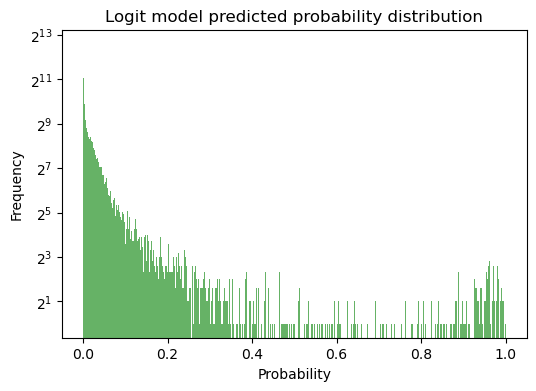

In [ ]:
import matplotlib.pyplot as plt
fix, ax2 = plt.subplots(figsize=(6, 4))
ax2.hist(y_pred_proba_logit, bins=1000, density=False, alpha=0.6, color='g')
#plt.ylim(0,5)
plt.yscale('log',base = 2)
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.title("Logit model predicted probability distribution")
plt.show

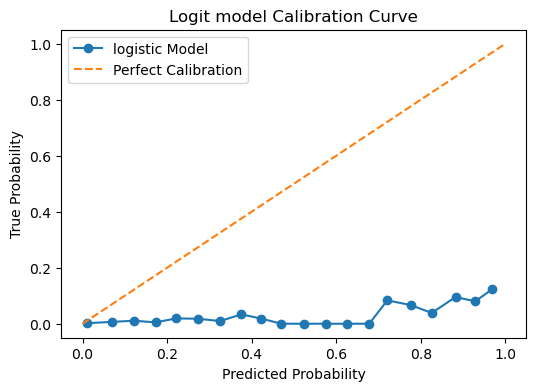

In [71]:
from sklearn.calibration import calibration_curve
trueprob,preprob = calibration_curve(y_test, y_pred_proba_logit, n_bins=20)
fig1, ax1 = plt.subplots(figsize=(6, 4))
ax1.plot(preprob, trueprob, marker='o', label='logistic Model')
ax1.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
ax1.set_xlabel('Predicted Probability')
ax1.set_ylabel('True Probability')
ax1.set_title('Logit model Calibration Curve')
ax1.legend()
plt.show()

### XGBOOST

In [ ]:
from xgboost import XGBClassifier

xgb_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        min_child_weight=10,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight = (y==0).sum() / (y==1).sum(),  # unbalanced adjustment
        eval_metric="aucpr",
        tree_method="hist",
        n_jobs=-1,
        random_state=42
    ))
])

xgb_model.fit(x_train, y_train)
y_pred_proba_xgb = xgb_model.predict_proba(x_test)[:,1]

print("AUROC:", roc_auc_score(y_test, y_pred_proba_xgb))
print("AUPRC:", average_precision_score(y_test, y_pred_proba_xgb))
print("Brier score:", brier_score_loss(y_test, y_pred_proba_xgb))

AUROC: 0.8588428497620492
AUPRC: 0.06141837895946893
Brier score: 0.08884509428866465


<function matplotlib.pyplot.show(close=None, block=None)>

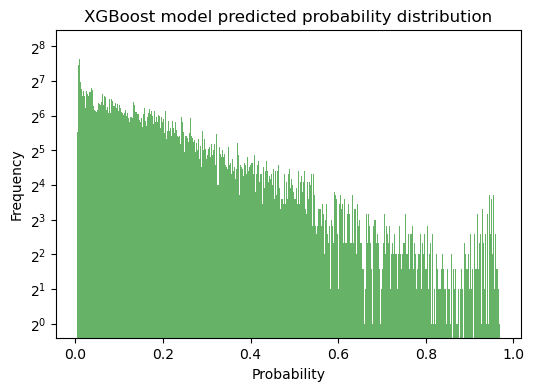

In [70]:
import matplotlib.pyplot as plt
fix, ax2 = plt.subplots(figsize=(6, 4))
ax2.hist(y_pred_proba_xgb, bins=1000, density=False, alpha=0.6, color='g')
#plt.ylim(0,10)
plt.yscale('log',base = 2)
plt.xlabel("Probability")
plt.ylabel("Frequency")
plt.title("XGBoost model predicted probability distribution")
plt.show

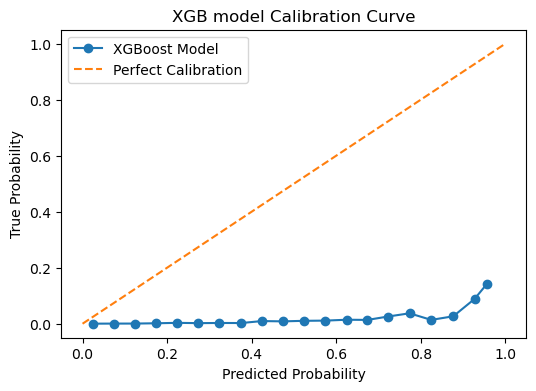

In [72]:
from sklearn.calibration import calibration_curve
trueprob,preprob = calibration_curve(y_test, y_pred_proba_xgb, n_bins=20)
fig1, ax1 = plt.subplots(figsize=(6, 4))
ax1.plot(preprob, trueprob, marker='o', label='XGBoost Model')
ax1.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
ax1.set_xlabel('Predicted Probability')
ax1.set_ylabel('True Probability')
ax1.set_title('XGB model Calibration Curve')
ax1.legend()
plt.show()


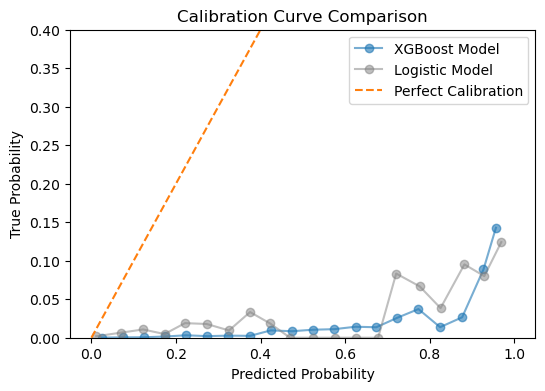

In [82]:
from sklearn.calibration import calibration_curve
trueprob_xgb,preprob_xgb = calibration_curve(y_test, y_pred_proba_xgb, n_bins=20)
trueprob_logit,preprob_logit = calibration_curve(y_test, y_pred_proba_logit, n_bins=20)
fig1, ax1 = plt.subplots(figsize=(6, 4))
ax1.plot(preprob_xgb, trueprob_xgb, marker='o', alpha=0.6,label='XGBoost Model')
ax1.plot(preprob_logit, trueprob_logit, marker='o', alpha = 0.5, color = 'gray',label='Logistic Model')
ax1.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
ax1.set_xlabel('Predicted Probability')
ax1.set_ylabel('True Probability')
ax1.set_title('Calibration Curve Comparison')
ax1.set_ylim(0,0.4)
ax1.legend()
plt.show()

### XGBoost Platt Scaling Calibration

In [84]:
from sklearn.calibration import CalibratedClassifierCV
xgb_platt = CalibratedClassifierCV(xgb_model.named_steps["model"], cv=5, method="sigmoid")
xgb_platt.fit(xgb_model.named_steps["preprocess"].transform(x_train), y_train)

y_pred_proba_xgb_platt = xgb_platt.predict_proba(xgb_model.named_steps["preprocess"].transform(x_test))[:,1]
print("AUROC:", roc_auc_score(y_test, y_pred_proba_xgb_platt))
print("AUPRC:", average_precision_score(y_test, y_pred_proba_xgb_platt))
print("Calibrated Brier:", brier_score_loss(y_test, y_pred_proba_xgb_platt))

AUROC: 0.8655433397835177
AUPRC: 0.06103487879612737
Calibrated Brier: 0.004018197167676583


<function matplotlib.pyplot.show(close=None, block=None)>

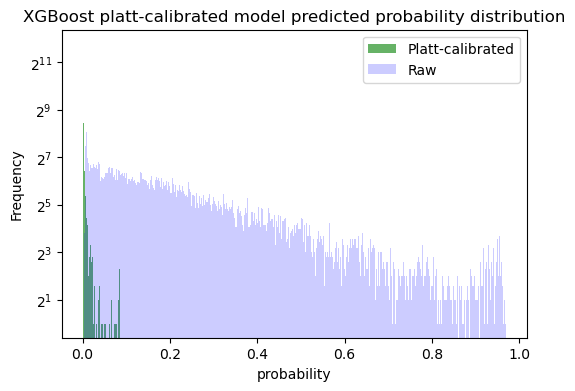

In [88]:
import matplotlib.pyplot as plt
fix, ax1 = plt.subplots(figsize=(6, 4))
ax1.hist(y_pred_proba_xgb_platt, bins=1000, density=False, alpha=0.6, color='g',label='Platt-calibrated')
ax1.hist(y_pred_proba_xgb, bins=1000, density=False, alpha=0.2, color='b',label='Raw')
#plt.ylim(0,10)
plt.xlabel("probability")
plt.ylabel("Frequency")
plt.title("XGBoost platt-calibrated model predicted probability distribution")
plt.legend()
plt.yscale('log',base = 2)
plt.show


In [ ]:
calibrated_pipe = CalibratedClassifierCV(
    estimator=xgb_model,  
    method="sigmoid",        
)
calibrated_pipe.fit(x_train, y_train)
y_pred_proba_cal_pipe = calibrated_pipe.predict_proba(x_test)[:,1]
print("Calibrated Brier (Pipeline):", brier_score_loss(y_test, y_pred_proba_cal_pipe))
print("AUROC (Pipeline):", roc_auc_score(y_test, y_pred_proba_cal_pipe))
print("AUPRC (Pipeline):", average_precision_score(y_test, y_pred_proba_cal_pipe))

Calibrated Brier (Pipeline): 0.004019221276240164
AUROC (Pipeline): 0.8633111267284729
AUPRC (Pipeline): 0.06379255781356702


### CITL calibration

In [89]:
import numpy as np, statsmodels.api as sm
from sklearn.base import clone
from scipy.special import logit, expit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss

eps = 1e-15
cv = 5  

def _rows(X, idx):
    if hasattr(X, "iloc"):   # pandas DataFrame/Series
        return X.iloc[idx]
    else:                    # numpy array / sparse matrix
        return X[idx]

# 1) traing_set as OOF 
oof_pred = np.empty(len(y_train), dtype=float)
skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
for tr, va in skf.split(x_train, y_train):
    X_tr, y_tr = _rows(x_train, tr), _rows(y_train, tr)
    X_va       = _rows(x_train, va)

    base = clone(xgb_model).fit(X_tr, y_tr)
    oof_pred[va] = base.predict_proba(X_va)[:, 1]

# 2)  GLM(Binomial) + offset fiting  CITL α：logit(p*) = logit(p_raw) + α
z = logit(np.clip(oof_pred, eps, 1-eps))
exog = np.ones((len(z), 1))  
glm = sm.GLM(y_train, exog, family=sm.families.Binomial(), offset=z)
res = glm.fit(cov_type="HC0")  
alpha = float(res.params[0])
print(f"CITL alpha = {alpha:.4f}")

# 3) implement on test set
y_pred_proba_xgb_citl = expit(logit(np.clip(y_pred_proba_xgb, eps, 1-eps)) + alpha)

# 4) printing results
print("Uncalibrated:",
      "AUROC=", roc_auc_score(y_test, y_pred_proba_xgb),
      "AUPRC=", average_precision_score(y_test, y_pred_proba_xgb),
      "Brier=", brier_score_loss(y_test, y_pred_proba_xgb))
print("CITL-calibrated:",
      "AUROC=", roc_auc_score(y_test, y_pred_proba_xgb_citl),  
      "AUPRC=", average_precision_score(y_test, y_pred_proba_xgb_citl),
      "Brier=", brier_score_loss(y_test, y_pred_proba_xgb_citl))

CITL alpha = -4.8955
Uncalibrated: AUROC= 0.8588428497620492 AUPRC= 0.06141837895946893 Brier= 0.08884509428866465
CITL-calibrated: AUROC= 0.8588430102143965 AUPRC= 0.06141837895946893 Brier= 0.0040082465618524795


/var/folders/j3/bd7_gpt90lz9_1v4q8kf1ygw0000gn/T/ipykernel_6245/810340254.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = float(res.params[0])


<function matplotlib.pyplot.show(close=None, block=None)>

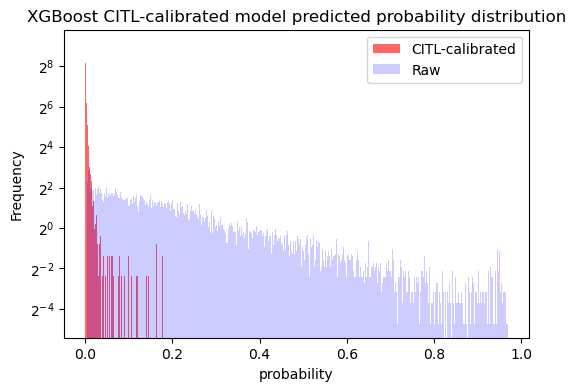

In [90]:
import matplotlib.pyplot as plt
fix, ax2 = plt.subplots(figsize=(6, 4))
ax2.hist(y_pred_proba_xgb_citl, bins=1000, density=True, alpha=0.6, color='r',label='CITL-calibrated')
ax2.hist(y_pred_proba_xgb, bins=1000, density=True, alpha=0.2, color='b',label='Raw')
#plt.ylim(0,10)
plt.xlabel("probability")
plt.ylabel("Frequency")
plt.title("XGBoost CITL-calibrated model predicted probability distribution")
plt.yscale('log',base = 2)
plt.legend()
plt.show

### Top-k metric

In [44]:
import numpy as np

K = [0.01, 0.03, 0.05, 0.075, 0.1]

def topk_metrics(y_true, y_prob, k=K):
    n = len(y_true)
    order = np.argsort(y_prob)[::-1]
    results = {}
    for rate in k:
        top_n = int(rate * n)
        idx = order[:top_n]
        recall = y_true.iloc[idx].sum() / y_true.sum()
        ppv = y_true.iloc[idx].sum() / top_n
        results[rate] = {'Recall': recall, 'Precision': ppv}
    return results

In [92]:
results_logit = topk_metrics(y_test, y_pred_proba_logit, k=K)
print(f'logit result:{results_logit}')

results_xgb = topk_metrics(y_test, y_pred_proba_xgb, k=K)
print(f'xgb result:{results_xgb}')

results_xgb_platt = topk_metrics(y_test, y_pred_proba_xgb_platt, k=K)
print(f'Platt calibrated XGB result:{results_xgb_platt}')

results_xgb_citl = topk_metrics(y_test, y_pred_proba_xgb_citl, k=K)
print(f'CITL calibrated XGB result:{results_xgb_citl}')

logit result:{0.01: {'Recall': np.float64(0.2631578947368421), 'Precision': np.float64(0.10948905109489052)}, 0.03: {'Recall': np.float64(0.3508771929824561), 'Precision': np.float64(0.04860267314702309)}, 0.05: {'Recall': np.float64(0.40350877192982454), 'Precision': np.float64(0.033527696793002916)}, 0.075: {'Recall': np.float64(0.4473684210526316), 'Precision': np.float64(0.02478134110787172)}, 0.1: {'Recall': np.float64(0.5087719298245614), 'Precision': np.float64(0.021137026239067054)}}
xgb result:{0.01: {'Recall': np.float64(0.23684210526315788), 'Precision': np.float64(0.09854014598540146)}, 0.03: {'Recall': np.float64(0.3684210526315789), 'Precision': np.float64(0.05103280680437424)}, 0.05: {'Recall': np.float64(0.47368421052631576), 'Precision': np.float64(0.03935860058309038)}, 0.075: {'Recall': np.float64(0.5175438596491229), 'Precision': np.float64(0.028668610301263362)}, 0.1: {'Recall': np.float64(0.5877192982456141), 'Precision': np.float64(0.024416909620991252)}}
Platt c

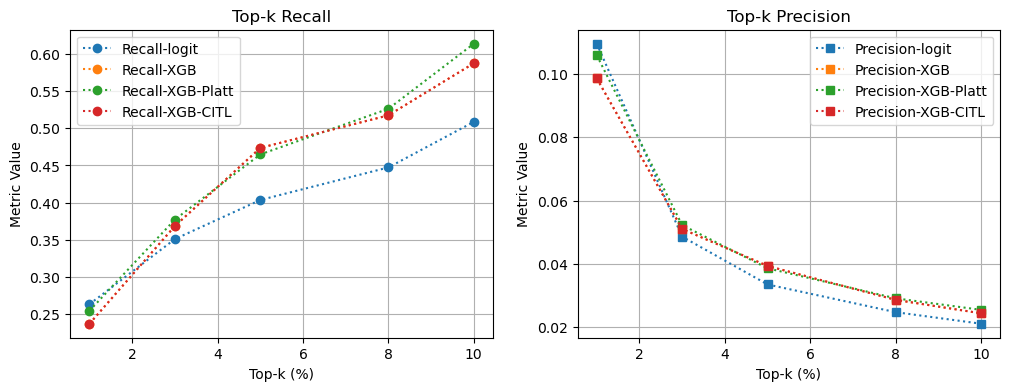

In [100]:
import matplotlib.pyplot as plt

k_vals = [round(k*100) for k in results_xgb.keys()]

recalls_logit = [v['Recall'] for v in results_logit.values()]
recalls_xgb = [v['Recall'] for v in results_xgb.values()]
recalls_xgb_platt = [v['Recall'] for v in results_xgb_platt.values()]
recalls_xgb_citl = [v['Recall'] for v in results_xgb_citl.values()]

precisions_logit = [v['Precision'] for v in results_logit.values()]
precisions_xgb = [v['Precision'] for v in results_xgb.values()]
precisions_xgb_platt = [v['Precision'] for v in results_xgb_platt.values()]
precisions_xgb_citl = [v['Precision'] for v in results_xgb_citl.values()]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.plot(k_vals, recalls_logit, marker='o',linestyle=':', label='Recall-logit')
ax2.plot(k_vals, precisions_logit, marker='s', linestyle=':',label='Precision-logit')
ax1.plot(k_vals, recalls_xgb, marker='o',linestyle=':', label='Recall-XGB')
ax2.plot(k_vals, precisions_xgb, marker='s', linestyle=':',label='Precision-XGB')
ax1.plot(k_vals, recalls_xgb_platt, marker='o',linestyle=':', label='Recall-XGB-Platt')
ax2.plot(k_vals, precisions_xgb_platt, marker='s', linestyle=':',label='Precision-XGB-Platt')
ax1.plot(k_vals, recalls_xgb_citl, marker='o',linestyle=':', label='Recall-XGB-CITL')
ax2.plot(k_vals, precisions_xgb_citl, marker='s', linestyle=':',label='Precision-XGB-CITL')
ax1.set_xlabel("Top-k (%)")
ax1.set_ylabel("Metric Value")
ax2.set_xlabel("Top-k (%)")
ax2.set_ylabel("Metric Value")
ax1.set_title("Top-k Recall")
ax2.set_title("Top-k Precision")
ax1.legend()
ax2.legend()
ax1.grid(True)
ax2.grid(True)
plt.show()